### Imports

In [1]:
import keras
from keras import backend as K

from keras.layers import Conv2D, BatchNormalization, Activation, Dense, Flatten, AveragePooling2D, Input
from keras.models import Model
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.datasets import cifar10

import numpy as np
import os

from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### Setting up hyper-parameters

In [2]:
batch_size = 128
version = 1
epochs = 50
data_augmentation = True
num_classes = 10

subtract_pixel_mean = True

# model parameter for calculating depth
number_of_res_blocks = 3

if version == 1:
    depth = (number_of_res_blocks * 6) + 2
elif version == 2:
    depth = (number_of_res_blocks * 9) + 2

model_type = f'resnet{depth}v{version}'; model_type

'resnet20v1'

### Load the data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
input_shape = x_train.shape[1:]; input_shape

(32, 32, 3)

In [0]:
# normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# we subtract the pixel mean of the training set from both the training and the validation or test set
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [8]:
print('x_train_shape', x_train.shape)
print(x_train.shape[0], ' training samples')
print(x_test.shape[0], ' test samples')
print('x_test_shape', x_test.shape)
print('y_train_shape', y_train.shape)

x_train_shape (50000, 32, 32, 3)
50000  training samples
10000  test samples
x_test_shape (10000, 32, 32, 3)
y_train_shape (50000, 1)


In [0]:
# convert the class vectors into binary class matrices
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [10]:
y_train[0], y_test[0]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32))

### Defining Resnet Layer

In [0]:
def resnet_layer(inputs, *,  kernel_size: int=3, num_filters: int=16, strides: int = 1, 
                 batch_normalization: bool = True, conv_first: bool = True, activation = 'relu'):
    
    """
    conv_first -> conv-bn-relu , else , bn-relu-conv
    """

    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    x = inputs

    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=num_classes) -> Model:
    """
    Stacks of 2 (3 x 3) resnet blocks are used.
    At the start of every stage, the image size is halved, by using a stride of 2.
    The number of channels are also doubled. The image size and number of channels remains 
    same in a single stage.

    Feature Map sizes:
        stage 0: 32 x 32, 16
        stage 1: 16 x 16, 32
        stage 2: 8 x 8, 64
    """

    if (depth - 2) % 6 != 0:
        raise ValueError('The depth value should be a multiple of 6')

    no_of_res_blocks = int((depth - 2) / 6)

    num_filters = 16
    inputs = Input(shape=input_shape)
    # input layer
    x = resnet_layer(inputs)

    for stage in range(3):
        for layer in range(no_of_res_blocks):
            stride = 1
            if stage > 0 and layer == 0:
                stride = 2

            y = resnet_layer(x, num_filters=num_filters, strides=stride)
            y = resnet_layer(y, num_filters=num_filters, strides=1, activation=None)

            if stage > 0 and layer == 0:
                x = resnet_layer(x , kernel_size=1, strides=stride, num_filters=num_filters, batch_normalization=False,
                                 activation=None)

            x = keras.layers.add([x , y])
            x = Activation('relu')(x)

        num_filters *= 2

    # Adding classifier on top
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
if version == 1: 
    model = resnet_v1(input_shape, depth)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10-%s-{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
reduce_lr = ReduceLROnPlateau(factor=0.7, patience=3, verbose=1, min_lr=1e-6)
checkpoints = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_acc')
callbacks = [checkpoints, reduce_lr]
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                             height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [0]:
datagen.fit(x_train)

In [0]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test), epochs=epochs, verbose=1, workers=4, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
391/391 [==============================] - 65s 167ms/step - loss: 1.6800 - acc: 0.4467 - val_loss: 1.7477 - val_acc: 0.4442

Epoch 00001: val_acc improved from -inf to 0.44420, saving model to /content/saved_models/cifar10-resnet20v1-epoch:03d.h5
Epoch 2/50
391/391 [==============================] - 56s 142ms/step - loss: 1.3210 - acc: 0.5789 - val_loss: 1.7652 - val_acc: 0.5009

Epoch 00002: val_acc improved from 0.44420 to 0.50090, saving model to /content/saved_models/cifar10-resnet20v1-epoch:03d.h5
Epoch 3/50
391/391 [==============================] - 55s 142ms/step - loss: 1.1375 - acc: 0.6467 - val_loss: 1.4989 - val_acc: 0.5740

Epoch 00003: val_acc improved from 0.50090 to 0.57400, saving model to /content/saved_models/cifar10-resnet20v1-epoch:03d.h5
Epoch 4/50
391/391 [==============================] - 55s 141ms/step - loss: 1.0144 - acc: 0.6930 - val_loss: 1.1532 - val_a

### Implement cutout using imgaug and reduce ImageAugmentation

In [18]:
!git clone https://github.com/yu4u/cutout-random-erasing

Cloning into 'cutout-random-erasing'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [19]:
%cd cutout-random-erasing/

/content/cutout-random-erasing


In [0]:
from random_eraser import get_random_eraser

In [0]:
eraser = get_random_eraser(v_l=0, v_h=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


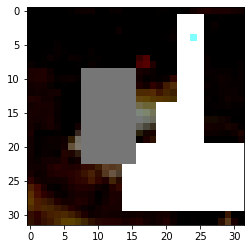

In [0]:
img = eraser(x_train[1])
plt.imshow(img, interpolation='nearest');

In [0]:
reduce_lr = ReduceLROnPlateau(factor=0.7, patience=4, verbose=1, min_lr=1e-6)
checkpoints = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_acc')
callbacks = [checkpoints, reduce_lr]
datagen = ImageDataGenerator(horizontal_flip=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                             width_shift_range=0.1, height_shift_range=0.1)

In [0]:
datagen.fit(x_train)

In [23]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test), epochs=epochs, verbose=1, workers=4, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
391/391 [==============================] - 38s 96ms/step - loss: 1.8042 - acc: 0.4090 - val_loss: 1.5138 - val_acc: 0.5140

Epoch 00001: val_acc improved from -inf to 0.51400, saving model to /content/saved_models/cifar10-resnet20v1-001.h5
Epoch 2/50
391/391 [==============================] - 30s 77ms/step - loss: 1.3858 - acc: 0.5554 - val_loss: 2.3198 - val_acc: 0.4033

Epoch 00002: val_acc did not improve from 0.51400
Epoch 3/50
391/391 [==============================] - 30s 76ms/step - loss: 1.2177 - acc: 0.6180 - val_loss: 1.2684 - val_acc: 0.6258

Epoch 00003: val_acc improved from 0.51400 to 0.62580, saving model to /content/saved_models/cifar10-resnet20v1-003.h5
Epoch 4/50
391/391 [==============================] - 30s 76ms/step - loss: 1.0997 - acc: 0.6611 - val_loss: 1.1563 - val_acc: 0.6435

Epoch 00004: val_acc improved from 0.62580 to 0.64350, saving model to /content

### Without Cutout

In [26]:
reduce_lr = ReduceLROnPlateau(factor=0.7, patience=3, verbose=1, min_lr=1e-6)
checkpoints = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True, monitor='val_acc')
callbacks = [checkpoints, reduce_lr]
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                             height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test), epochs=epochs, verbose=1, workers=4, callbacks=callbacks)

Epoch 1/50
391/391 [==============================] - 35s 88ms/step - loss: 1.7092 - acc: 0.4353 - val_loss: 1.5667 - val_acc: 0.4766

Epoch 00001: val_acc improved from -inf to 0.47660, saving model to /content/saved_models/cifar10-resnet20v1-001.h5
Epoch 2/50
391/391 [==============================] - 29s 75ms/step - loss: 1.3063 - acc: 0.5827 - val_loss: 1.2700 - val_acc: 0.5967

Epoch 00002: val_acc improved from 0.47660 to 0.59670, saving model to /content/saved_models/cifar10-resnet20v1-002.h5
Epoch 3/50
391/391 [==============================] - 30s 76ms/step - loss: 1.1022 - acc: 0.6605 - val_loss: 1.3330 - val_acc: 0.6176

Epoch 00003: val_acc improved from 0.59670 to 0.61760, saving model to /content/saved_models/cifar10-resnet20v1-003.h5
Epoch 4/50
391/391 [==============================] - 29s 75ms/step - loss: 0.9945 - acc: 0.7010 - val_loss: 1.1835 - val_acc: 0.6458

Epoch 00004: val_acc improved from 0.61760 to 0.64580, saving model to /content/saved_models/cifar10-resne

In [0]:
from pathlib import Path

In [15]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ML-Models'

# save in google drive
dir_path = Path(base_dir)
dir_path.mkdir(parents=True, exist_ok=True)

Mounted at /content/gdrive


In [0]:
!cp /content/saved_models/cifar10-resnet20v1-044.h5 /content/gdrive/My\ Drive/ML-Models/

In [0]:
# (x, y, channel, no_of_filters) -> output of get weights [weights, bias], for weights
def display_weights_of_a_channel_of_a_layer(*, layer_num: int = 0, channel_num: int = 0, cmap: str = None):
    layer_1_weights  = model.layers[layer_num].get_weights()[0][:, :, channel_num, :]
    no_of_kernels = len(layer_1_weights[0, 0, :])
    row_num, col_num = 2, no_of_kernels // 2

    fig, ax = plt.subplots(row_num, col_num, figsize=(30, 6))
    kernel_num = 0
    for row in range(row_num):
        for col in range(col_num):
            ax[row][col].imshow(layer_1_weights[:, :, kernel_num], cmap=cmap)
            kernel_num += 1

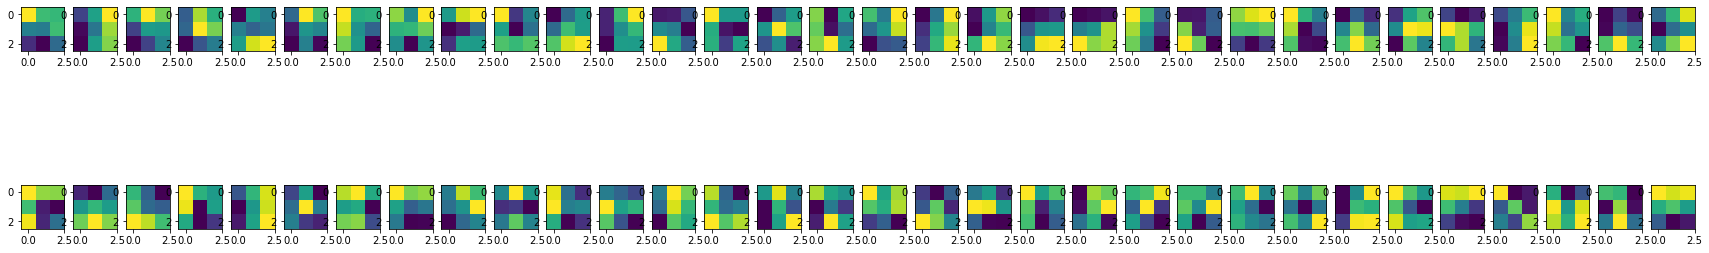

In [61]:
display_weights_of_a_channel_of_a_layer(layer_num=-7, channel_num=0)

In [48]:
model.layers[4].get_weights()[0].shape

(3, 3, 16, 16)

In [0]:
from keras.models import load_model

In [0]:
model = load_model('/content/gdrive/My Drive/ML-Models/cifar10-resnet20v1-044.h5')

In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

## All Grad-CAM labelled images are at the very end

### GRAD CAM

In [0]:
# images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

actual_images = {
    'airplane': 'https://images.unsplash.com/photo-1532973497172-04b34d604825?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=741&q=80',
    'automobile': 'https://www.abcconsultants.in/wp-content/uploads/2018/01/Automobile__Auto_Components_707x418-min.jpg',
    'bird': 'https://www.thespruce.com/thmb/bS1rvJQcPY2BwMoeAOT_l8x__0Q=/960x0/filters:no_upscale():max_bytes(150000):strip_icc()/red-summer-tanager-58991d123df78caebc049ac4.jpg',
    'cat': 'https://images.unsplash.com/photo-1482066490729-6f26115b60dc?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80',
    'deer': 'https://media.gettyimages.com/photos/deer-fawn-picture-id168504892?s=612x612',
    'dog': 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=0.669xw:1.00xh;0.166xw,0&resize=640:*',
    'frog': 'https://images.unsplash.com/photo-1550853123-b81beb0b1449?ixlib=rb-1.2.1&dpr=1&auto=format&fit=crop&w=416&h=312&q=60',
    'horse': 'https://images.unsplash.com/photo-1553284965-5dd8352ff1bd?ixlib=rb-1.2.1&w=1000&q=80',
    'ship': 'https://upload.wikimedia.org/wikipedia/commons/b/b3/Zenith_%28ship%2C_1992%29.jpg',
    'truck': 'https://www.tatamotors.com/wp-content/uploads/2018/01/19065024/prima.jpg'
}

In [0]:
from skimage import io
from google.colab.patches import cv2_imshow
import cv2
from keras.preprocessing import image

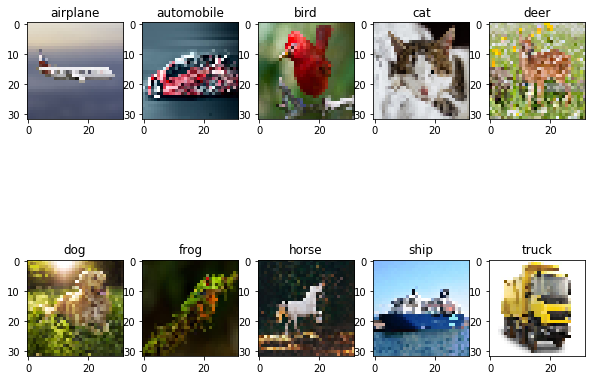

In [37]:
_, ax = plt.subplots(2, 5, figsize=(10, 8))
row_num, col_num = 2, 5

row, col = 0, 0 
for name, url in actual_images.items():
    try:
        if col == 5:
            col = 0
            row += 1
        image = io.imread(url)
        image = cv2.resize(image, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        ax[row][col].imshow(image)
        ax[row][col].set_title(name)
        col += 1

    except:
        print(url)

In [0]:
frog = io.imread("https://images.unsplash.com/photo-1550853123-b81beb0b1449?ixlib=rb-1.2.1&dpr=1&auto=format&fit=crop&w=416&h=312&q=60")
frog = cv2.resize(frog, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(frog)
x = np.expand_dims(x, axis=0)

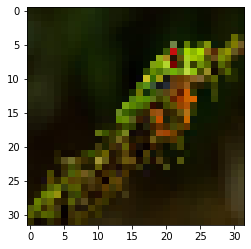

In [58]:
plt.imshow(frog);

In [0]:
# preprocess image
x /= 255
x -= x_train_mean

In [60]:
preds = model.predict(x)
class_idx = np.argmax(preds[0]); class_idx

6

In [0]:
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("add_18")

In [62]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

(?, 8, 8, 64)
(64,)


In [0]:

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [64]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(8, 8, 64)
(8, 8)


In [0]:
heatmap = cv2.resize(heatmap, (frog.shape[1], frog.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(frog, 0.5, heatmap, 0.5, 0)


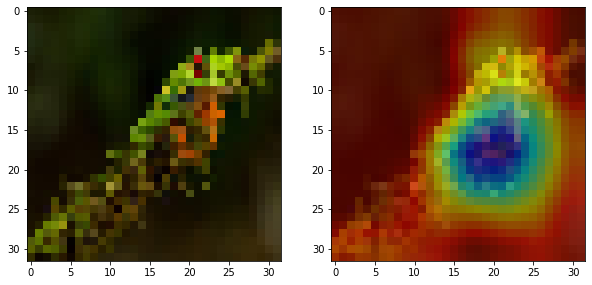

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)

ax[0][0].imshow(frog)
ax[0][1].imshow(superimposed_img);

In [0]:
def display_all_gradcam_images(class_names: list, actual_images: dict):
    _, ax = plt.subplots(4, 5, figsize=(20, 14))
    row, col = 0, 0 
    
    for name, url in actual_images.items():
        
        if col == 5:
            row += 2
            col = 0

        img = io.imread(url)
        img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        # preprocess image
        x /= 255
        x -= x_train_mean

        preds = model.predict(x)
        class_idx = np.argmax(preds[0])
        predicted_class_name = class_names[class_idx]

        class_output = model.output[:, class_idx]
        last_conv_layer = model.get_layer("add_18")

        grads = K.gradients(class_output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) 

        pooled_grads_value, conv_layer_output_value = iterate([x])

        for i in range(64):
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i] 

        heatmap = np.mean(conv_layer_output_value, axis = -1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

        ax[row][col].imshow(img);
        ax[row][col].set_title(f'Actual: {name}')

        ax[row+1][col].imshow(superimposed_img);
        ax[row+1][col].set_title(f'Predicted: {predicted_class_name}')

        col += 1

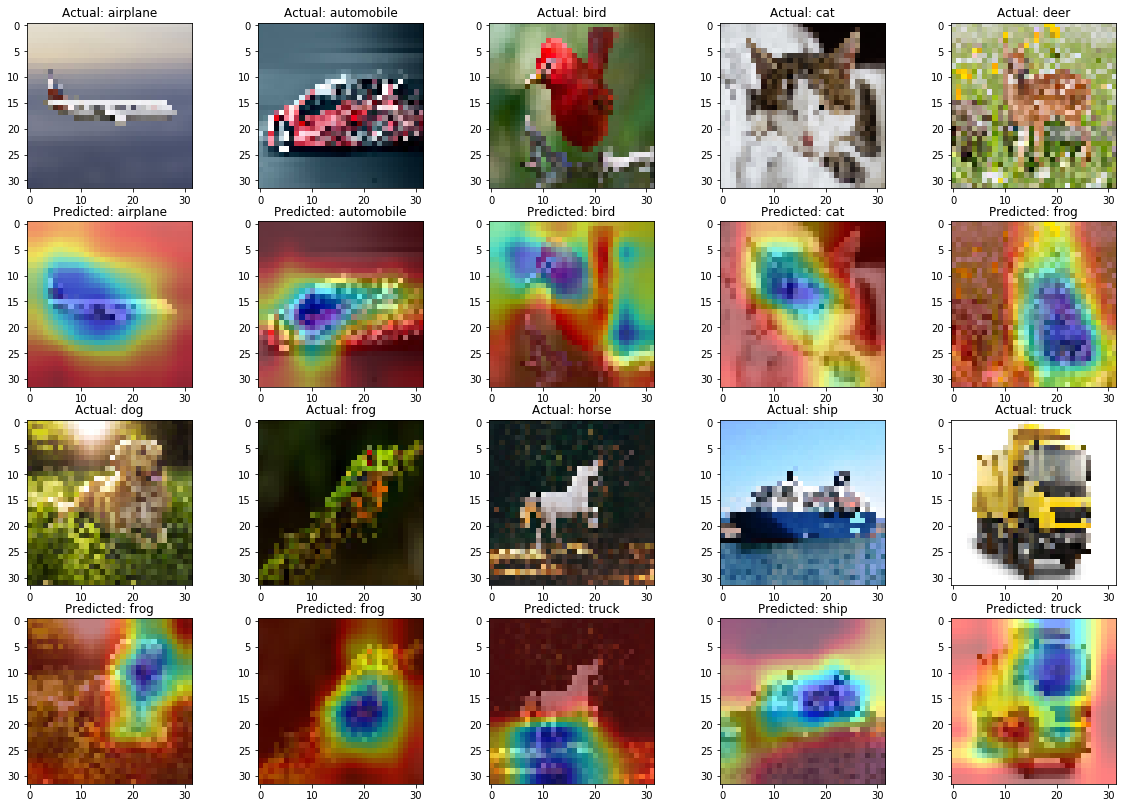

In [48]:
display_all_gradcam_images(class_names, actual_images)